# Importing the Libraries

In [1]:
from skmob.tessellation.tilers import tiler as main_tiler
from skmob.utils.plot import plot_gdf
from tilers import tiler
import warnings
from datetime import datetime

import geopandas as gpd
import numpy as np

warnings.filterwarnings("ignore")

# Function to get the shape of a OSM object

To avoid working directly with OSM I used the already implemented tilers to get a random point in the city (extracting a centroid), then I perform a Voronoi tessellation of one point (which is performed on 1+4 points, 4 being the external bound of the tessellation to bound the tessellation in the earth area, which otherwise would go towards infinity)

In [2]:
def _get_shape(shape):
    # I only need point close to the base_shape, thus I can be very generous with side meters
    get_point = main_tiler.get('squared', base_shape=shape, meters=1e5)\
                          .loc[0]['geometry'].centroid

    # A Voronoi of one point will just return the base_shape of the city
    extracted_shape = tiler.get('voronoi', points = [get_point], base_shape = shape)
    
    return extracted_shape

# Function to get random points inside a OSM shape

Using the function wrote here above I first build a bounding box around the shape by extracting the exterior coordinates and selecting the min and max of the x and y axes.

Then if a seed is not set, points are generated until the fill a list up until a maximum value 'k' set at the begining, an ulterior condition to be added to the list is to be within the bounding box.

To avoid putting too much computational complexity in the while loop (I didn't want conditions too difficult too uphold by the algorithm) and to avoid going back and forth from a GeoDataFrame: I set externally a filter to select only the points within the original shape.

Result is a GeoDataFrame with only a column of points inside the input shape

In [3]:
from shapely.geometry import Point

def get_rannd_points_in_shape(shape, k = 10, seed = None):
    # THE OUTPUT NUMBER OF POINTS WILL BE TYPICALLY LOWER THAN 'k':
    # 'k' is the higher bound, it must be set higher than the number of desired points
    
    # getting the shape and the exterior vertices
    extracted_shape = _get_shape(shape)
    xmin, ymin, xmax, ymax = extracted_shape.total_bounds
    
    generated_points = list()
    
    # to guarantee reproducibility
    if seed:
        np.random.seed(seed)
    
    while len(generated_points) < k:
        # random x and y coordinate within the specified min and max coordinates
        x = np.random.uniform(xmin, xmax+1)
        y = np.random.uniform(ymin, ymax+1)

        # checking if the coordinates are within the limits for both axes
        if xmin <= x <= xmax and ymin <= y <= ymax:
            generated_points.append(Point(x, y))
            
    # filtering only to points appearing in the extracted shape
    point_in_shape = gpd.GeoDataFrame(geometry=generated_points).sjoin(extracted_shape)
    
    # selecting only the geometry and resetting index (before the sjoin I had indexes from 1 to k)
    out_points = point_in_shape[['geometry']].reset_index(drop=True)
    
    print(f'Number of points generated: {len(out_points)}')
        
    return out_points

# Voronoi on random points in Milan

This seed produces 51 points, as a result the Voronoi will produce 51 polygons/multipolygons. With Milan the number of points resulting from the generation, if k is sufficiently large, is around half $k$ as the area in the bounding box of the max and min x and y axes coordinates not part of the city is about the same as the one part of the city. 

This observation is just a guess after multiple tests with larger and larger number of points, the distribution of resulting approximate around a little more than $k \div 2$.

**IMPORTANT**: Multipolygons are generated only if a point is around a concave area of a city and the area on the other side of the concave parte is closer to the point in question. This happens with this seed in the bottom part of the city. It is due to the fact the Voronoi is computed with a "larger than earth" external bound, as the most external site events of the Voronoi would naturally generate polygons with 'infinite' halfilines

In [4]:
generated_points = get_rannd_points_in_shape('Milano', k=100, seed = 42)
generated_points.head()

Number of points generated: 51


geometry
0  POINT (9.16557 45.40768)
1  POINT (9.20669 45.41981)
2  POINT (9.20961 45.40345)
3  POINT (9.17277 45.47308)
4  POINT (9.20327 45.42411)

In [5]:
voronoi = tiler.get('voronoi', points = generated_points, base_shape = 'Milano')
print(f'Number of Tiles: {len(voronoi)}')
voronoi.head()

Number of Tiles: 51


tile_ID                                           geometry
0       0  POLYGON ((9.14177 45.41998, 9.17659 45.42400, ...
1       1  POLYGON ((9.19754 45.41603, 9.20923 45.42535, ...
2       2  MULTIPOLYGON (((9.20398 45.39525, 9.20378 45.3...
3       3  POLYGON ((9.16572 45.45575, 9.15494 45.46892, ...
4       4  POLYGON ((9.18454 45.42115, 9.18244 45.42268, ...

In [ ]:
plot_points = plot_gdf(generated_points, zoom = 12)
plot_gdf(voronoi, map_f = plot_points)

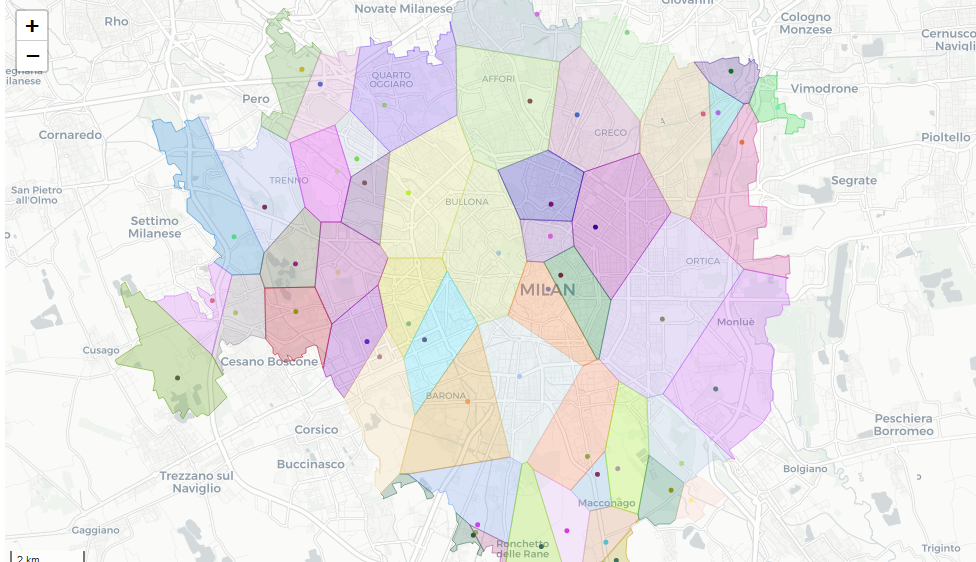

# Random points with a higher concentration in the center

I thought up this as cities usually seem to have a higher concentration of people towards their center, and I thought to how would I use this fact to divide the space.

I computed a normally distributed sample of points. So I would get a radial distribution from the center of my input.

In [7]:
milan = _get_shape('Milano')
city_center = milan.geometry[0].centroid
std = 0.02 # looking at the coordinates, equal for both axis as hypothesis of a circular city
n_points = 100

np.random.seed(42)
npx = np.random.normal(city_center.x, std, n_points).reshape(-1, 1) #reshape them vertically
npy = np.random.normal(city_center.y, std, n_points).reshape(-1, 1)
norm_points = np.hstack((npx, npy)) #stack them horizontally to have 2 cols

points_in_milan = gpd.GeoDataFrame(geometry=[Point(xy) for xy in norm_points]).sjoin(milan)

In [ ]:
voronoi = tiler.get('voronoi', points = points_in_milan, base_shape = 'Milano')
print(f'Number of Tiles: {len(voronoi)}')
plot_gdf(voronoi, zoom = 12)

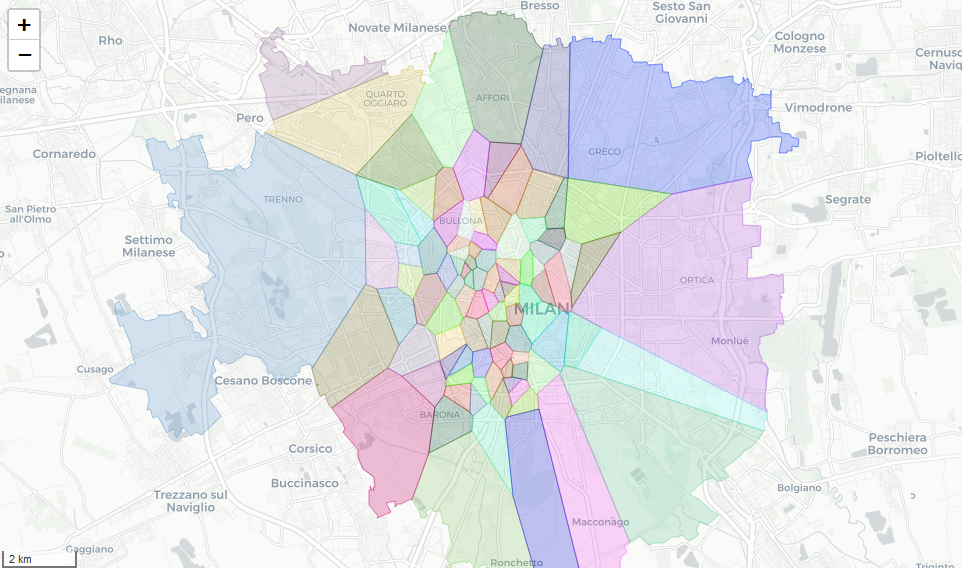

# Comparison with Squared and H3 Tessellation

In the case of getting a pure random tessellation of a city, the advantage of the Voronoi is the fact it doesn't need to specify the size of the areas by which the space should be divided. 

Further more if the information about the size of the population of each part of the city was available it would also be possible to generate random points with a higher frequency close to the areas where the populations is concetrated, so that it would be possible to get a more equally distributed importance across all tiles (to apply some specific model where including the importance is more difficult), I just presented a case of a population concentrated to the center of the city (but this is just a hypothesis).

The vornoi tessellation also allow to manually divide the city into sectors by just inputting the important places. It may come in hand when there is some knowledge and unstructured data about places but no structured information easily available.

As it can be seen these advantages comes at the cost of the reliability of the input points. The other two tilers are way more parameter free, having only to specify the side of the polygons.

In [ ]:
sq = main_tiler.get('squared', base_shape = 'Milano', meters = 1500)
plot_gdf(sq, zoom = 12)

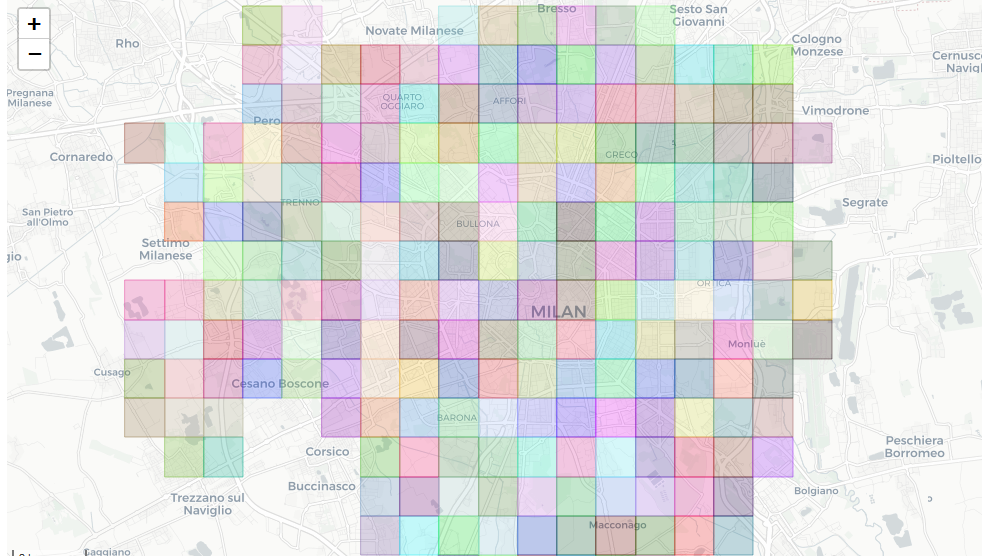

In [ ]:
h3 = main_tiler.get('h3_tessellation', base_shape = 'Milano', meters = 700)
plot_gdf(h3, zoom = 12)

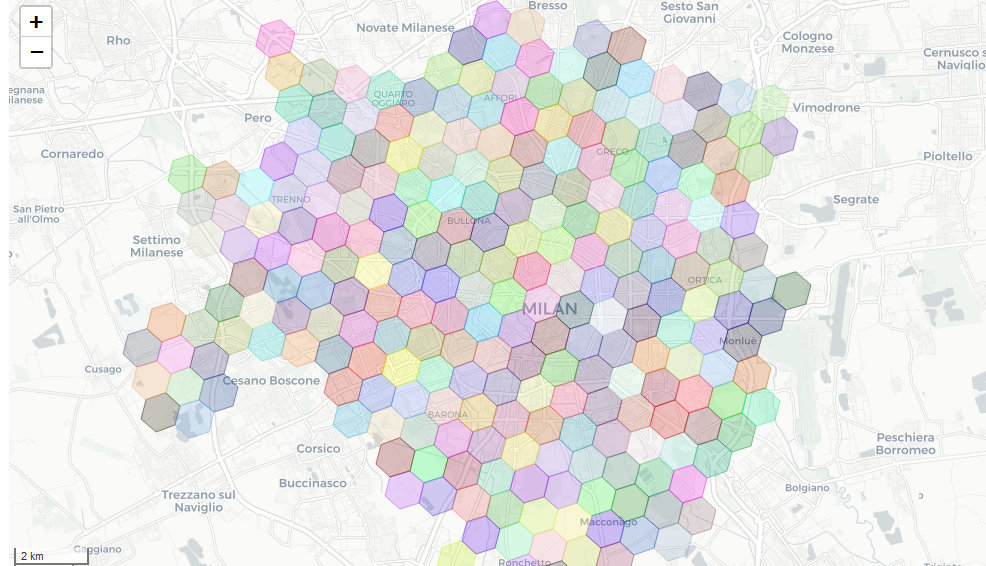

# Trying wit a OpenCellID dataframe

Considering the current context I wrote this small function to get the cells that are inside a an area slightly larger than the city.

Contrary to the previous toy example I decided not to filter to only the points within the city as it may be possible that in this context there may be some external cell towers capturing areas around the extern borders of the city while still within it. 

It may be excessive caution on my part considering that approximations are needed anyway (in sparsely populated areas there may be a cell farther than what is considered reasonable), as such I preferred to work with a buffer parameter in the case of strange occurences. 

As it can be seen though the buffer is quite small (it should correspond to around 5km larger than the shape in all directions). The get the simplest case I avoided (only points within the city just set buffer to zero.

In [11]:
def filter_gdf_to_shape(geoDataFrame, shape, buffer = 0.05):
    
    extracted_shape = _get_shape(shape)    
    buffered_shape = extracted_shape.geometry[0].buffer(buffer)
    buffered_gdf = gpd.GeoDataFrame(geometry=[buffered_shape])
    
    # Getting the intersection with the original GDF
    # I get points within the original area + buffer
    return gpd.sjoin(geoDataFrame, buffered_gdf).reset_index(drop = True)

It takes some time to read the file (about 150mb)

In [12]:
start_time = datetime.now()
japanese_cells = gpd.read_file('JapanCells/440.csv')
end_time = datetime.now()
print(f"Time required to read: {end_time-start_time}")

Time required to read: 0:01:43.392584


In [13]:
japanese_cells.head()

field_1 field_2 field_3 field_4   field_5 field_6          field_7  \
0    UMTS     440      10      42  71090310       0  139.74403381348   
1    UMTS     440      10      42  71090220       0       139.743285   
2    UMTS     440      10      42  71090313       0  139.74403381348   
3    UMTS     440      10      51  68272295       0  139.76600646973   
4    UMTS     440      10     267  14991631       0  139.70420837402   

           field_8 field_9 field_10 field_11    field_12    field_13 field_14  \
0  35.659561157227    1000        2        1  1311169227  1311169227        0   
1        35.660934    1000       11        1  1311169511  1311169511        0   
2  35.662307739258    1000        1        1  1311169541  1311169541        0   
3  35.732345581055    1000        2        1  1311171499  1311171499        0   
4  35.816116333008    1000        1        1  1311172537  1311172537        0   

  geometry  
0     None  
1     None  
2     None  
3     None  
4     None

In [14]:
# adding the geometries from the coordinates
japanese_cells['geometry'] = gpd.points_from_xy(japanese_cells.field_7, japanese_cells.field_8)

Now filtering to only a single city only

In [15]:
japan_city = 'Hirosaki, Japan'
japan_cells = filter_gdf_to_shape(japanese_cells, japan_city)
# japan_cells[['geometry']].to_file('jp')

As it can be seen some cells near Hirosaki along the costline have been kept with the default $0.05$ buffer with the previous assumption of "some close cells could reach the city"

In [ ]:
plot_gdf(japan_cells, zoom = 11)

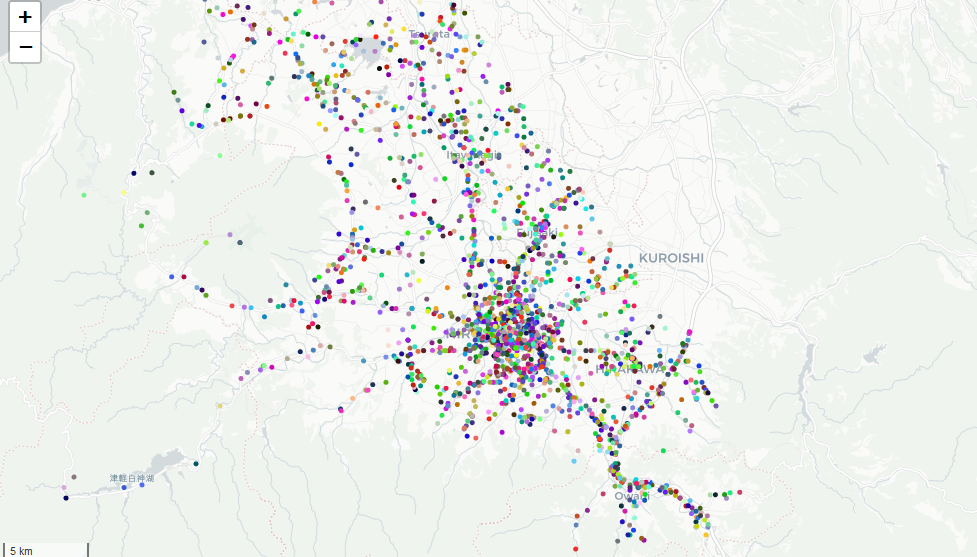

Plotting the tessellation

In [ ]:
start_time = datetime.now()
voronoi = tiler.get('voronoi', points = japan_cells, base_shape = japan_city)
print(f'Number of Tiles: {len(voronoi)}')
end_time = datetime.now()
print(f"Time required to compute: {end_time-start_time}")
plot_gdf(voronoi, zoom = 11)

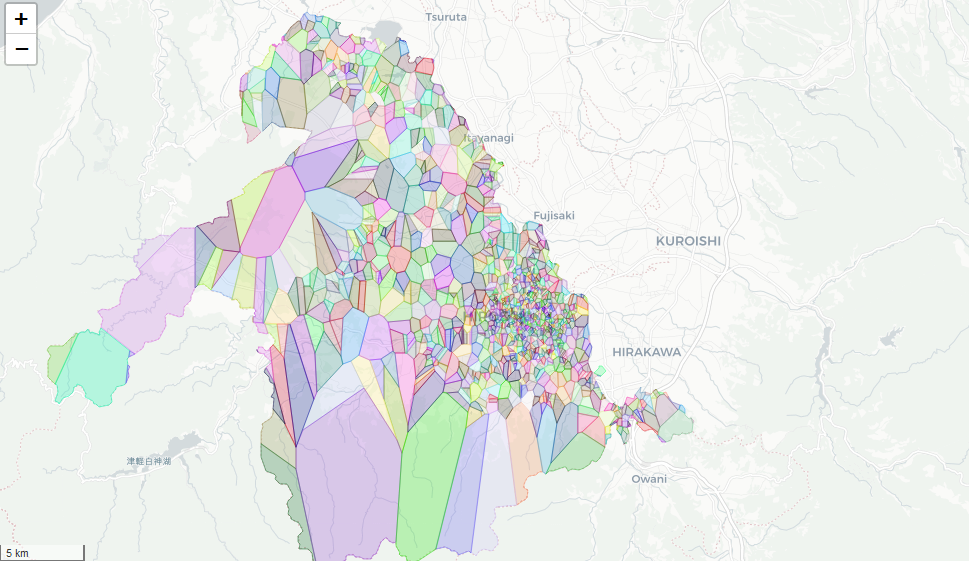

# Voronoi of the European Union

Here a slightly more recreational example. Subdividing the European Union with a Voronoi tessellation with the capitals coordinates as its input points

In [19]:
# It's a little bit annoying but it is faster than looking for jsons around
# !pip install countrygroups
# !pip install pycountry_convert
# !pip install countryinfo

In [20]:
from countrygroups import EUROPEAN_UNION
import pycountry_convert.convert_countries as pycountry
from countryinfo import CountryInfo

In [21]:
eu_shapes = dict()

for iso3 in EUROPEAN_UNION:
    iso2 = pycountry.country_alpha3_to_country_alpha2(iso3)
    country = pycountry.country_alpha2_to_country_name(iso2)
    country_shape = _get_shape(country).geometry[0]
    # different name conventions across different libraries
    country = 'Czech Republic' if country == 'Czechia' else country
    capital = CountryInfo(country).capital()
    
    try: # Copenhagen is picked from the U.S. state of NY even if Denmark is specified
        capital_center = _get_shape(f'{capital}, {country}, {iso2}').geometry[0].centroid
    except: # Athen cannot be found with the iso2 'GR' at the end
        capital_center = _get_shape(f'{capital}, {country}').geometry[0].centroid
    
    eu_shapes[country] = (country_shape, capital_center)

In [22]:
eu_gdf = gpd.GeoDataFrame(eu_shapes).T.reset_index()
eu_gdf.columns = ['country', 'geometry', 'capitals']
eu_gdf = gpd.GeoDataFrame(eu_gdf).set_crs("EPSG:4326")

Getting a single "European Union" geometry

In [23]:
eu_gdf['unifier'] = [0]*len(eu_gdf)
eu_shape = eu_gdf.dissolve(by='unifier')[['geometry']]

Getting the capitals as input points into a geodataframe (I need the gdf just to plot them, for the voronoi they can be also lists or arrays of points or [lon, lat] tuples)

In [24]:
eu_capitals = gpd.GeoDataFrame(geometry = [capital for _, capital in eu_shapes.values()])

In [ ]:
eu_map = plot_gdf(eu_shape, zoom = 4)
plot_gdf(eu_capitals, map_f= eu_map)

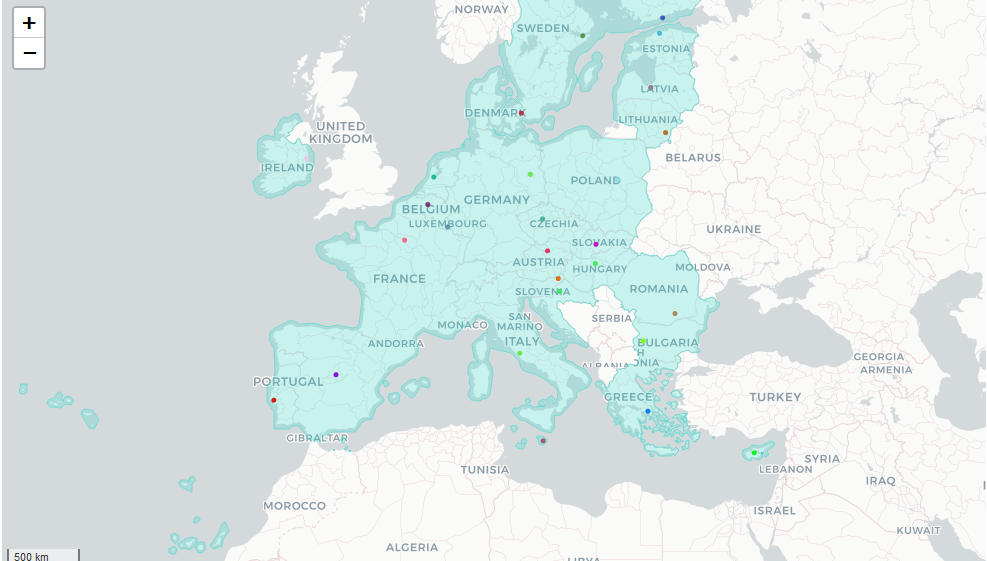

Getting the tessellation

In [26]:
voronoi = tiler.get('voronoi', points = eu_capitals, base_shape = eu_shape)
print(f'Number of Tiles: {len(voronoi)}')
voronoi.head()

Number of Tiles: 27


tile_ID                                           geometry
0       0  POLYGON ((10.38891 48.13455, 16.91850 49.67799...
1       1  POLYGON ((5.91880 51.17207, 4.29802 48.91840, ...
2       2  MULTIPOLYGON (((20.61233 40.07921, 20.61396 40...
3       3  MULTIPOLYGON (((171.99970 -22.20733, 172.00652...
4       4  POLYGON ((10.30354 49.70544, 17.23418 52.73887...

Plotting it.

In [ ]:
plot_points = plot_gdf(eu_capitals, zoom = 4)
plot_gdf(voronoi, map_f = plot_points)

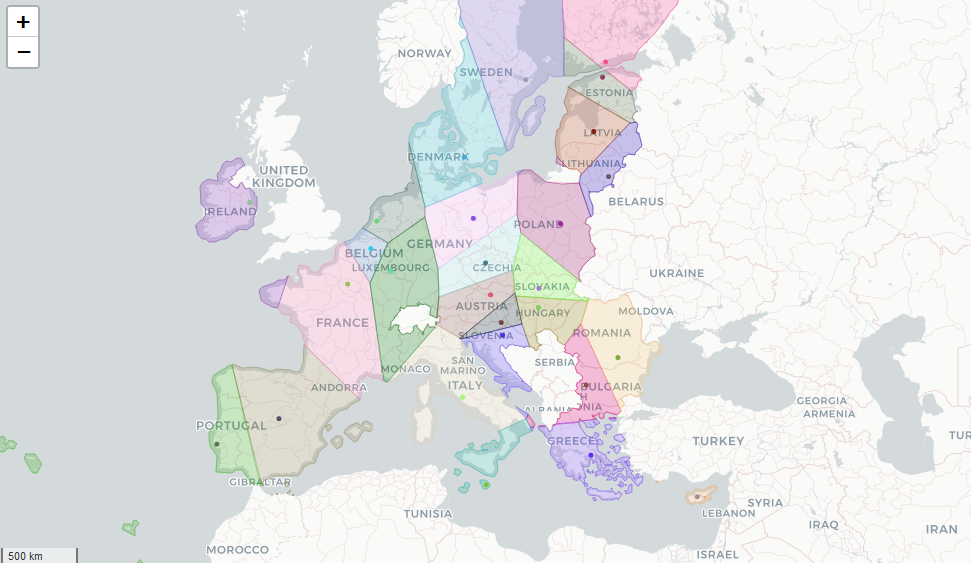

Except for the center-east of europe the area closest to the capitals seems to recreate some historical borders.

It shows as the brittany region is closer to Dublin than Paris or how the presence of Luxembourg (like a small Lotharingia) messes up the border areas of France and Germany for which some wars have been disputed.

Fun to notice overseas territories would be owned either by Portugal or Cyprus